### **Biblioteca e Carregamento dos Dados**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display            import Markdown
import warnings
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold
from skopt import gp_minimize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from functions import *
from sklearn.feature_selection import SelectKBest, chi2
from plotly.subplots import make_subplots


warnings.filterwarnings("ignore")


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
''' Utilizaremos uma função que está no pacote functions para poder observar os dados, sabendo asssim a quantidade de valores nulos, únicos e tipo das variáveis.'''
df_informations(train)

<H3 style='text-align:left;float:lfet;'>Information about the Dataset

<H5> Dataset has 8693 rows and 14 columns. From these, we have:

,Not Null,Null,Perce Null,Unique,Dtype
PassengerId,8693,0,0.00%,8693,object
HomePlanet,8693,201,2.31%,3,object
CryoSleep,8693,217,2.50%,2,object
Cabin,8693,199,2.29%,6560,object
Destination,8693,182,2.09%,3,object
Age,8693,179,2.06%,80,float64
VIP,8693,203,2.34%,2,object
RoomService,8693,181,2.08%,1273,float64
FoodCourt,8693,183,2.11%,1507,float64
ShoppingMall,8693,208,2.39%,1115,float64


<H3 style='text-align:left;float:lfet;'>About Dtypes we have:

,Dtype,Perce
object,7,50.00%
float64,6,43.00%
bool,1,7.00%


In [4]:
''' Como podemos verificar existe alguns outliers no dataset, iremos precisar trata-lo mais a frente.'''

train.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()

,count,mean,std,min,1%,25%,50%,75%,90%,99%,max
Age,8514.0,28.827930,14.489021,0.0,0.0,19.0,27.0,38.0,49.0,65.00,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,0.0,47.0,753.0,3096.23,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,0.0,76.0,1026.0,8033.31,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,0.0,27.0,619.6,2333.44,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,0.0,59.0,732.0,5390.10,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,0.0,46.0,732.6,5646.68,24133.0


### **Tratamento dos dados**

#### **Coluna HomePlanet**

In [5]:
''' Como podemos verificar 2.31% dos dados são nulos, após observar os dados não foi possível localizar outras colunas para preencher esses valores adequadamente, dessa forma como Earth possui 52.93% dos dados iremos preencher
os valores nulos como Earth'''

train['HomePlanet'].value_counts(dropna=False, normalize=True)*100

Earth     52.939146
Europa    24.513977
Mars      20.234672
NaN        2.312205
Name: HomePlanet, dtype: float64

In [6]:
train['HomePlanet'].fillna('Earth', inplace= True)

#### **Coluna CryoSleep**

In [7]:
''' Utilizaremos a mediana para preencher o valor nulo da coluna CryoSleep'''

train['CryoSleep'].value_counts(normalize=True, dropna= False)*100

False    62.567583
True     34.936156
NaN       2.496261
Name: CryoSleep, dtype: float64

In [8]:
if np.median(train['CryoSleep']) == 0:
    print('Preencher como False')

elif np.median(train['CryoSleep']) == 1:
    print('Preencher como True')

else:
    print('Error')

Preencher como False


In [9]:
train['CryoSleep'].fillna(False, inplace=True)

#### **Coluna Destination**

In [10]:
''' Como o destino TRAPPIST-1e são mais de 68% dos valores iremos preencher o valor nulo com esse destino'''

train['Destination'].value_counts(normalize=True, dropna= False)*100

TRAPPIST-1e      68.043253
55 Cancri e      20.706315
PSO J318.5-22     9.156793
NaN               2.093639
Name: Destination, dtype: float64

In [11]:
train['Destination'].fillna('TRAPPIST-1e', inplace=True)

#### **Coluna Age**

In [12]:
''' A coluna Age iremos preencher os valores nulos de acordo com a média da idade, que no caso é 28. '''
media_idade = int(np.mean(train['Age']))
train['Age'].fillna(media_idade, inplace=True)

#### **Coluna VIP**

In [13]:
''' Utilizaremos a mediana para preencher o valor nulo da coluna VIP'''

train['VIP'].value_counts(normalize=True, dropna= False)*100

False    95.375590
NaN       2.335212
True      2.289198
Name: VIP, dtype: float64

In [14]:
if np.median(train['VIP']) == 0:
    print('Preencher como False')

elif np.median(train['VIP']) == 1:
    print('Preencher como True')

else:
    print('Error')

Preencher como False


In [15]:
train['VIP'].fillna(False, inplace=True)

#### **Restante das Colunas**

In [16]:
''' As colunas de gastos como RoomService, FoodCourt, ShoppingMall, Spa e VRDeck serão todas preenchidas com a média.'''

rs_mean = np.mean(train['RoomService'])
foodcourt_mean = np.mean(train['FoodCourt'])
shopping_mean = np.mean(train['ShoppingMall'])
spa_mean = np.mean(train['Spa'])
vr_mean = np.mean(train['VRDeck'])


In [17]:
train['RoomService'].fillna(rs_mean,inplace= True)
train['FoodCourt'].fillna(foodcourt_mean,inplace= True)
train['ShoppingMall'].fillna(shopping_mean,inplace= True)
train['Spa'].fillna(spa_mean,inplace= True)
train['VRDeck'].fillna(vr_mean,inplace= True)

#### **Criando novas features**

In [18]:
''' Observando os dados podemos criar novas colunas que podem ajudar o modelo a se sair melhor 

Dentro do dicionário dos dados é informado que dentro da colunas PassengerID os 4 primeiros valores refere-se ao grupo no qual os passageiros estão viajando, sendo assim irei fazer o split para retirar esses 4 valores
e iremos armazenar esse valor em uma nova coluna chamada PassengerGroup.
Criaremos também uma outra coluna chamada Group_Size, irá receber como valor a quantidade de pessoas no mesmo grupo.
'''

train['PassengerGroup'] = train['PassengerId'].str.split('_').str.get(0)

train['Group_Size'] = train.groupby('PassengerGroup')['PassengerGroup'].transform('count')

In [19]:
''' Quanto a coluna Cabin dentro do dicionário informa que ela é dividida em 3 partes, sendo a primeira parte referente ao deck que se encontra a cabine, a segunda o número da cabine e a terceira o lado
sendo S para starboard e P para port, iremos também extrair os 3 elementos utilizando o mesmo método e criar 3 novas colunas e uma coluna adicional chamada total_cost que será a soma das 5 colunas de gastos.
'''
train['Deck'] = train['Cabin'].str.split('/').str.get(0)
train['Number_Cabin'] = train['Cabin'].str.split('/').str.get(1)
train['Side_Cabin'] = train['Cabin'].str.split('/').str.get(2)
train['total_cost'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck'] 


In [20]:
''' Como existia alguns valores nulos na coluna Cabin iremos utilizar o fillna para preencher os valores que também irão migrar para as novas colunas as categorias irei preencher com o valor mais presente e as continuas com 0.
    Após isso as coluans Number_Cabin e PassengerGroup que estão no formato object serão transformadas para int64'''

train['PassengerGroup'].fillna(0, inplace=True)
train['Deck'].fillna('F', inplace=True)
train['Number_Cabin'].fillna(0, inplace=True)
train['Side_Cabin'].fillna('P', inplace=True)

train['Number_Cabin'] = train['Number_Cabin'].astype('int64')
train['PassengerGroup'] = train['PassengerGroup'].astype('int64')

In [21]:
''' Com isso podemos agora excluir algumas colunas que não serão utilizadas a partir daqui, são elas PassengerID, Cabin e Name.'''

train.drop(['PassengerId', 'Cabin', 'Name'], axis= 1, inplace= True)

### **Análise gráfica**

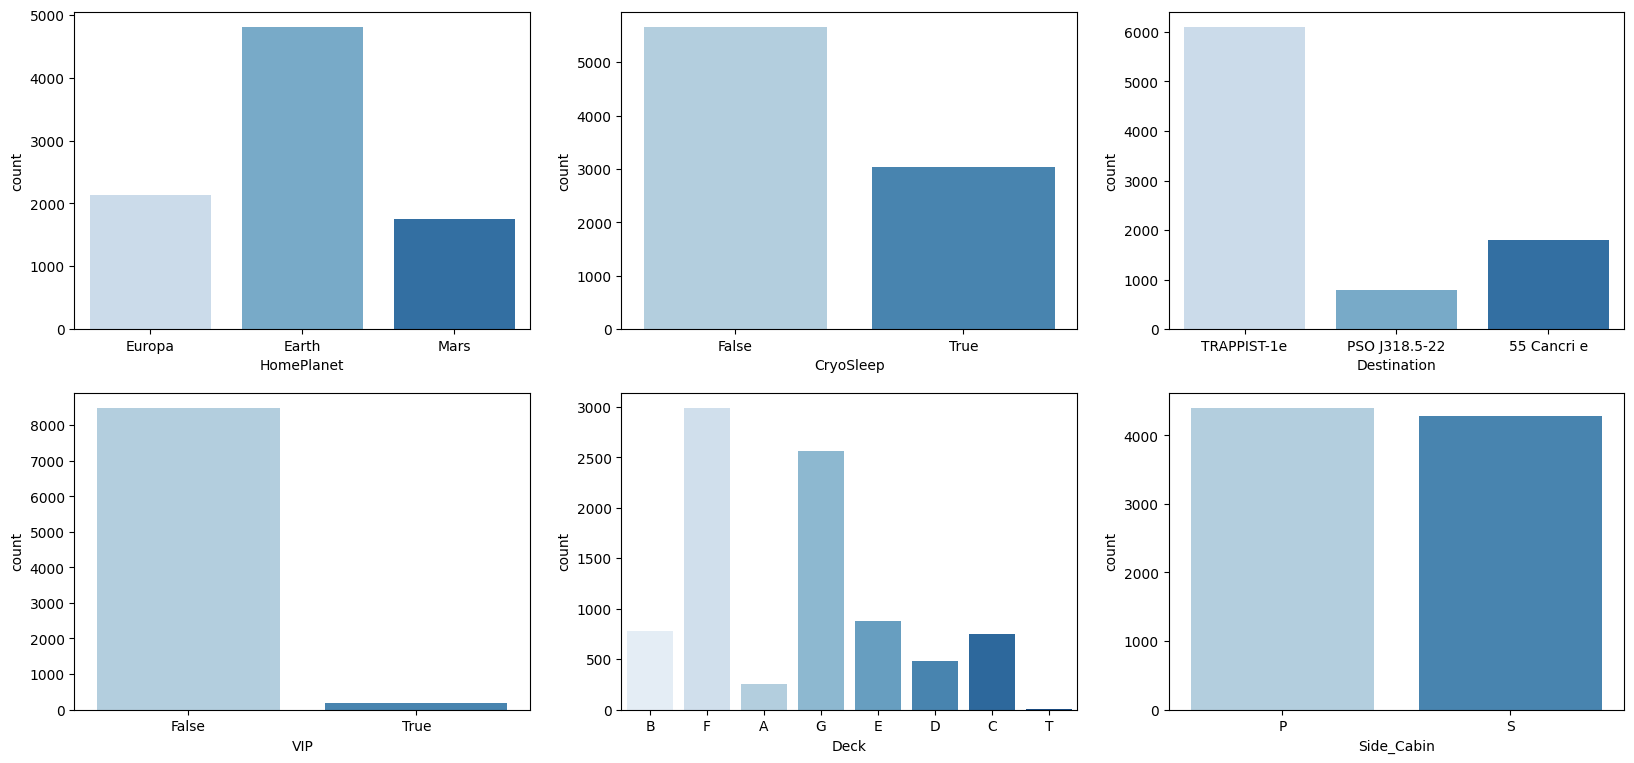

In [22]:
''' Iremos verificar a distribuição dos dados das colunas categoricas separadas pela variável target. '''

fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(3,3)
axe0 = fig.add_subplot(gs[0,0])
axe1 = fig.add_subplot(gs[0,1])
axe2 = fig.add_subplot(gs[0,2])
axe3 = fig.add_subplot(gs[1,0])
axe4 = fig.add_subplot(gs[1,1])
axe5 = fig.add_subplot(gs[1,2])

sns.countplot(ax= axe0, data= train, x= 'HomePlanet', palette="Blues")

sns.countplot(ax= axe1, data= train, x= 'CryoSleep',palette="Blues")

sns.countplot(ax= axe2, data= train, x= 'Destination', palette="Blues")

sns.countplot(ax= axe3, data= train, x= 'VIP',palette="Blues")

sns.countplot(ax= axe4, data= train, x= 'Deck',palette="Blues")

sns.countplot(ax= axe5, data= train, x= 'Side_Cabin', palette="Blues");



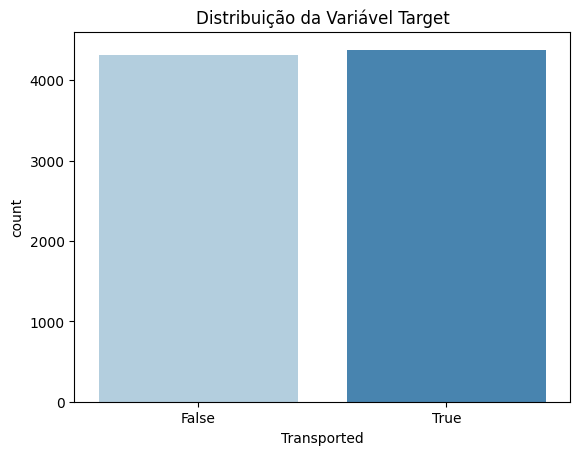

In [23]:
''' Como podemos ver no gráfico a distriuibação da variável target é quase a mesma para True and False.'''
plt.title('Distribuição da Variável Target')
sns.countplot(data= train, x= 'Transported', palette="Blues");

In [24]:
''' Como podemos ver a coluna Age tem sua principal distribuição entre 18 e 28 anos e após isso vai apresentando uma queda'''

fig = px.histogram(train, x="Age", nbins=40)
fig.show(renderer="png", width=1600, height=650)

In [25]:
''' Referente as outras colunas continuas como RoomService, FoodCourt, SPA e VRDeck todas seguem uma distribuição muito semelhante conforme mostra gráficos abaixo.'''
fig = px.histogram(train, x="RoomService", nbins=15)
fig.show(renderer="png", width=1600, height=650)

In [26]:
fig = px.histogram(train, x="FoodCourt", nbins=15)
fig.show(renderer="png", width=1600, height=650)

In [27]:
fig = px.histogram(train, x="ShoppingMall", nbins=15)
fig.show(renderer="png", width=1600, height=650)

In [28]:
fig = px.histogram(train, x="Spa", nbins=15)
fig.show(renderer="png", width=1600, height=650)

In [29]:
fig = px.histogram(train, x="VRDeck", nbins=15)
fig.show(renderer="png", width=1600, height=650)

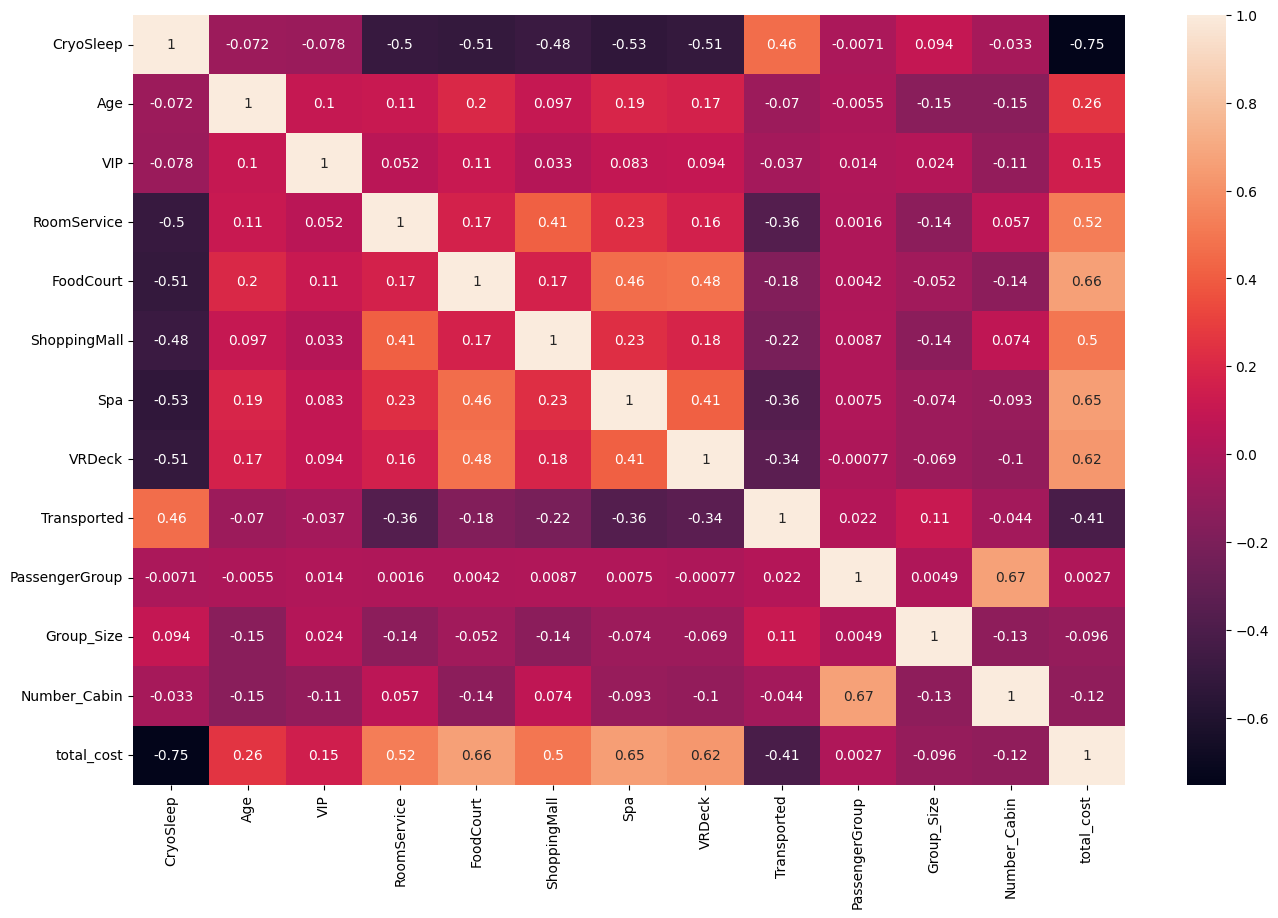

In [30]:
fig = plt.figure(figsize=(16,10))
sns.heatmap(train.corr(method='spearman'), annot=True);

### **Transformações dos Dados**

In [31]:
''' Nessa parte como os modelos não conseguem ler variáveis categóricas iremos transforma-las em numéricas e os valores que estão atualmente como True and False em 0 e 1
    Quanto as categóricas utilizaremos o get_dummies do pandas para fazer a transformação.'''
    
def group_size_cat(groupSize):
        if groupSize == 1:
            return 'Sozinho'
        elif groupSize == 2:
            return 'Casal'
        elif groupSize < 4:
            return 'Familia'
        elif groupSize >= 4:
            return 'Grupo'

train['Group_Size'] = train['Group_Size'].map(group_size_cat)



cal_categ = train.select_dtypes('object').columns
train = pd.get_dummies(data = train, columns = cal_categ)

train[['CryoSleep', 'VIP', 'Transported']] = train[['CryoSleep', 'VIP', 'Transported']].astype('int64')

### **Isolation Forest (Outliers)**

##### **O que é o IsolationForest?**

Isolation Forest é um algoritmo de detecção de anomalia usado para identificar pontos de dados incomuns em um conjunto de dados. Ele funciona dividindo recursivamente o conjunto de dados em subconjuntos menores, procurando pontos de dados que sejam isolados dos demais. Esses pontos de dados isolados são considerados anômalos.

O algoritmo funciona criando uma floresta de árvores de decisão, onde cada árvore é treinada para identificar pontos de dados isolados. Quanto mais cedo uma árvore consegue identificar um ponto de dados como anômalo, menor será o seu escore de isolamento. Pontos de dados com escores mais baixos são considerados mais anômalos.

In [32]:
''' Após observar os dados e fazer alguns testes foi definido como 2% o parâmetro contamination do Isolation Forest, sendo assim o algorítmo irá considerar que 2% dos dados são anômalos e remove-los.'''
ISO = IsolationForest(contamination=0.2)

ISO.fit(train)

ISO_pred = ISO.predict(train)

train_iso = train[ISO_pred != -1]

train_iso = train.copy()

In [33]:
train_iso.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()

,count,mean,std,min,1%,25%,50%,75%,90%,99%,max
CryoSleep,8693.0,0.349362,0.476796,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.0
Age,8693.0,28.810882,14.339536,0.0,0.0,20.0,27.0,37.0,49.0,65.00,79.0
VIP,8693.0,0.022892,0.149568,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.0
RoomService,8693.0,224.687617,659.739364,0.0,0.0,0.0,0.0,78.0,741.0,3087.24,14327.0
FoodCourt,8693.0,458.077203,1594.434978,0.0,0.0,0.0,0.0,118.0,985.0,7992.32,29813.0
ShoppingMall,8693.0,173.729169,597.417440,0.0,0.0,0.0,0.0,45.0,610.0,2317.12,23492.0
Spa,8693.0,311.138778,1124.675871,0.0,0.0,0.0,0.0,89.0,722.0,5294.52,22408.0
VRDeck,8693.0,304.854791,1133.259049,0.0,0.0,0.0,0.0,71.0,716.8,5567.16,24133.0
Transported,8693.0,0.503624,0.500016,0.0,0.0,0.0,1.0,1.0,1.0,1.00,1.0
PassengerGroup,8693.0,4633.389624,2671.028856,1.0,92.0,2319.0,4630.0,6883.0,8344.8,9184.08,9280.0


### **Construção dos modelos**

In [34]:
''' Fazendo a divisão dos dados em X e y'''

X = train_iso.drop(columns='Transported')
y = train_iso['Transported']

#### **Feature Selection**

##### **O que é Feature Selection?**

Feature selection é o processo de selecionar as características (ou "features" em inglês) mais relevantes em um conjunto de dados para serem usadas em um modelo de aprendizado de máquina. Isso é importante porque menos características significam menos ruído e menos overfitting, o que geralmente leva a um modelo mais preciso.

#### **Como funciona o método SelectKBest?**

SelectKBest com Chi2 é uma técnica de seleção de características baseada em filtragem, onde seleciona as k características mais relevantes de um conjunto de dados com base no teste de qui-quadrado (Chi2), comparando as frequências observadas de uma determinada característica em diferentes classes com as frequências esperadas se as características e as classes fossem independentes. As k características com os valores mais altos de teste de qui-quadrado são consideradas as mais relevantes para a classificação.

In [35]:
''' Após alguns testes foi definido que a quantidade mínima de features que o modelo apresenta um resultado satisfatório é com 25 features.'''

feature_se = SelectKBest(chi2, k= 25)
fit = feature_se.fit(X, y)
cols_sel = fit.get_support(indices=True)

X = X.iloc[:,cols_sel]

In [36]:
''' Fazendo a separação do X e do y em treino e teste para poder fazer a seleção de features.'''

X_train, X_teste, y_train, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

#### **Random Forest Classifier**

##### **Tunning de Hiperparâmetros.**

Bayesian Optimization é um método para encontrar os parâmetros ótimos de um modelo de aprendizado de máquina. Ele funciona criando um modelo probabilístico da função objetivo a ser otimizada e, em seguida, usando técnicas de otimização para encontrar o ponto de máximo (ou mínimo) desse modelo. A cada iteração, o algoritimo avalia a função objetivo em um ponto de parâmetros proposto e, em seguida, atualiza seu modelo probabilístico com base nessa avaliação, permitindo que o algoritimo aprenda sobre a função objetivo e proponha pontos de parâmetros cada vez mais promissores.

In [37]:
def treinar_modelo(params):
    max_depth = params[0]
    n_jobs = params[1]
    max_leaf_nodes = params[2]
    max_samples = params[3]

    print(params, '\n')
    

    mdl = RandomForestClassifier(max_depth=max_depth, n_jobs=n_jobs, 
                                 max_leaf_nodes=max_leaf_nodes, 
                                 max_samples=max_samples, n_estimators=350, random_state=42)

    mdl.fit(X_train, y_train)

    p = mdl.predict_proba(X_teste)[:, 1]

    return -roc_auc_score(y_teste, p)


space = [(1, 40), # max_depth
         (1, 11), # n_jobs
         (2, 35), # max_leaf_nodes
         (1, 30)] # max_samples
RS_RF = gp_minimize(treinar_modelo, space, n_calls=30, random_state=42, verbose = 0)

[32, 3, 28, 18] 

[18, 2, 17, 11] 

[7, 8, 4, 22] 

[38, 1, 35, 19] 

[25, 1, 3, 16] 

[17, 1, 34, 8] 

[5, 7, 15, 30] 

[19, 10, 24, 14] 

[2, 10, 21, 12] 

[2, 3, 10, 21] 

[40, 11, 22, 30] 

[12, 2, 31, 30] 

[40, 1, 2, 30] 

[22, 10, 23, 30] 

[40, 10, 35, 30] 

[40, 8, 2, 1] 

[1, 11, 35, 30] 

[40, 1, 25, 27] 

[40, 1, 35, 13] 

[40, 1, 29, 30] 

[6, 1, 35, 13] 

[1, 1, 2, 30] 

[40, 8, 35, 24] 

[40, 7, 27, 30] 

[40, 11, 13, 23] 

[24, 11, 2, 30] 

[40, 1, 20, 28] 

[12, 1, 20, 30] 

[12, 1, 21, 26] 

[40, 1, 17, 20] 



In [38]:
print('Os parâmetros escolhidos pelo Bayesian Optimization foram:')
print()
print('Max_Depht =',RS_RF.x[0])
print('N_jobs =',RS_RF.x[1])
print('Max_leaf_nodes =',RS_RF.x[2])
print('Max_Samples =',RS_RF.x[3])

Os parâmetros escolhidos pelo Bayesian Optimization foram:

Max_Depht = 40
N_jobs = 11
Max_leaf_nodes = 22
Max_Samples = 30


In [39]:
Result_RF = []
RF_Model = RandomForestClassifier(max_depth = RS_RF.x[0],
                                n_jobs = RS_RF.x[1],
                                max_leaf_nodes = RS_RF.x[2],
                                max_samples = RS_RF.x[3],
                                n_estimators=350, random_state=42)

#### **Validação Cruzada e Resultado do Modelo**

Validação cruzada é um método utilizado para avaliar a precisão de um modelo de aprendizado de máquina. Ele funciona dividindo os dados de treinamento em vários conjuntos menores, conhecidos como "folds", e, em seguida, treinando e avaliando o modelo em cada um desses folds. Isso permite avaliar o desempenho do modelo em diferentes conjuntos de dados e obter uma estimativa mais precisa da precisão do modelo.

In [40]:
Cross_validation(RF_Model, X, y, Result_RF)

Repetição:  0
Treino 6519
Valid 2174
Repetição: 0
Acurácia: 0.7516099356025759

Treino 6520
Valid 2173
Repetição: 0
Acurácia: 0.7326277036355269

Treino 6520
Valid 2173
Repetição: 0
Acurácia: 0.7565577542567878

Treino 6520
Valid 2173
Repetição: 0
Acurácia: 0.7800276115968707

Repetição:  1
Treino 6519
Valid 2174
Repetição: 1
Acurácia: 0.7516099356025759

Treino 6520
Valid 2173
Repetição: 1
Acurácia: 0.7418315692590888

Treino 6520
Valid 2173
Repetição: 1
Acurácia: 0.7634606534744592

Treino 6520
Valid 2173
Repetição: 1
Acurácia: 0.7547169811320755

Repetição:  2
Treino 6519
Valid 2174
Repetição: 2
Acurácia: 0.7612695492180312

Treino 6520
Valid 2173
Repetição: 2
Acurácia: 0.7445927289461574

Treino 6520
Valid 2173
Repetição: 2
Acurácia: 0.7413713759779107

Treino 6520
Valid 2173
Repetição: 2
Acurácia: 0.7606994937873907

Repetição:  3
Treino 6519
Valid 2174
Repetição: 3
Acurácia: 0.7571297148114076

Treino 6520
Valid 2173
Repetição: 3
Acurácia: 0.742291762540267

Treino 6520
Valid 217

In [41]:
print('O modelo de Random forest teve a acurácia de:', np.mean(Result_RF))

O modelo de Random forest teve a acurácia de: 0.754172923223418


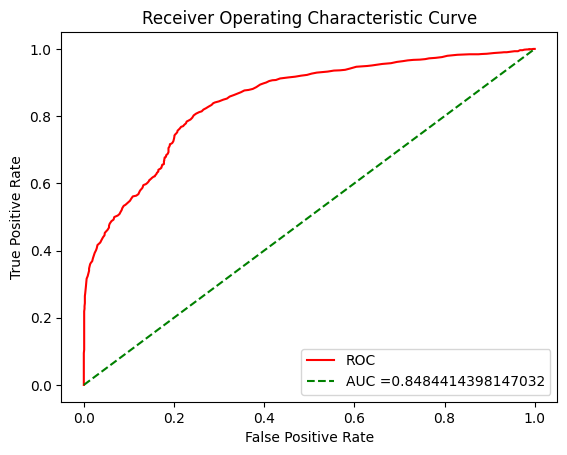

In [42]:
plot_roc_curve(X_teste, y_teste, RF_Model)

#### **XGBoost Classifier Model**

In [43]:
def treinar_modelo_XGB(params):
    gamma = params[0]
    max_depth = params[1]
    learning_rate = params[2]
    colsample_bytree  = params[3]
    scale_pos_weight  = params[4]
    subsample  = params[5]
   # n_estimators = params[6]
    print(params, '\n')
    

    mdl_XGB = XGBClassifier(gamma = gamma,
                            learning_rate=learning_rate, max_depth=max_depth, 
                            colsample_bytree =colsample_bytree , 
                            reg_lambda=0,
                            scale_pos_weight =scale_pos_weight,
                            subsample = subsample,
                            n_estimators=300, random_state=42)

    mdl_XGB.fit(X_train, y_train)

    p = mdl_XGB.predict_proba(X_teste)[:, 1]

    return -roc_auc_score(y_teste, p)

space_XGB = [(0.3, 8), # gamma
             (2, 6), # max_depth
             (0.01, 0.5), # learning_rate
             (0.1, 0.7), # colsample_bytree
             (0, 2), #scale_pos_weight
             (0.1,0.8)] # subsample

Bay_XGB = gp_minimize(treinar_modelo_XGB, space_XGB, n_calls=30, random_state=42, verbose = 0)

[6.433380998823795, 3, 0.39204859013365706, 0.4581100947678922, 1, 0.16998244107260205] 

[3.8362164681371778, 3, 0.08000474078175099, 0.4905330837693118, 0, 0.6053991405867775] 

[7.5268558594212776, 2, 0.4961836640526967, 0.47048890577662994, 1, 0.1049464136538022] 

[0.4775806728189014, 4, 0.20593187614047526, 0.12799939792816928, 2, 0.262939938301213] 

[0.9976695459027203, 4, 0.1974063757209098, 0.689938531484073, 1, 0.7019582847154245] 

[5.538368047125904, 4, 0.0164998309683346, 0.6653210534109117, 1, 0.36979155177794143] 

[0.42294014209564934, 3, 0.12810247835274577, 0.509958111295275, 1, 0.6832364382153152] 

[1.6349078320098454, 4, 0.09929568301615055, 0.5532168461905916, 1, 0.24555916400773223] 

[4.671292524213935, 2, 0.4227195395515494, 0.36985248002185944, 1, 0.7486612060556561] 

[5.8999943680944416, 3, 0.2895175474586458, 0.4125005560154943, 2, 0.6911736940747062] 

[8.0, 6, 0.01, 0.7, 2, 0.8] 

[8.0, 6, 0.01, 0.1, 1, 0.8] 

[8.0, 2, 0.5, 0.1, 2, 0.1] 

[0.3, 3, 0.01, 

In [44]:

print('Os parâmetros escolhidos pelo Bayesian Optimization foram:')
print()
print('Gamma =',RS_XGB.x[0])
print('Max_Depht =',RS_XGB.x[1])
print('learning_rate =',RS_XGB.x[2])
print('colsample_bytree =',RS_XGB.x[3])
print('scale_pos_weight =',RS_XGB.x[4])
print('subsample =',RS_XGB.x[5])

Os parâmetros escolhidos pelo Bayesian Optimization foram:



NameError: name 'RS_XGB' is not defined

In [ ]:
Result_XGB = []
XGB_Model = XGBClassifier(objective="binary:logistic",
                          gamma= RS_XGB.x[0], max_depth=RS_XGB.x[1],
                          learning_rate=RS_XGB.x[2],
                          colsample_bytree =RS_XGB.x[3] , 
                          reg_lambda=0,
                          scale_pos_weight =RS_XGB.x[4],
                          subsample = RS_XGB.x[5],
                          n_estimators=300, random_state=42)

#### **Validação Cruzada e Resultado do Modelo**

In [ ]:
Cross_validation(XGB_Model, X, y, Result_XGB)

Repetição:  0
Treino 6519
Valid 2174
Repetição: 0
Acurácia: 0.8049678012879485

Treino 6520
Valid 2173
Repetição: 0
Acurácia: 0.7929130234698574

Treino 6520
Valid 2173
Repetição: 0
Acurácia: 0.8076392084675563

Treino 6520
Valid 2173
Repetição: 0
Acurácia: 0.8080994017487345

Repetição:  1
Treino 6519
Valid 2174
Repetição: 1
Acurácia: 0.8141674333026679

Treino 6520
Valid 2173
Repetição: 1
Acurácia: 0.7979751495628163

Treino 6520
Valid 2173
Repetição: 1
Acurácia: 0.8094799815922687

Treino 6520
Valid 2173
Repetição: 1
Acurácia: 0.8016566958122412

Repetição:  2
Treino 6519
Valid 2174
Repetição: 2
Acurácia: 0.8095676172953082

Treino 6520
Valid 2173
Repetição: 2
Acurácia: 0.8104003681546249

Treino 6520
Valid 2173
Repetição: 2
Acurácia: 0.7988955361251726

Treino 6520
Valid 2173
Repetição: 2
Acurácia: 0.8002761159687068

Repetição:  3
Treino 6519
Valid 2174
Repetição: 3
Acurácia: 0.7989880404783809

Treino 6520
Valid 2173
Repetição: 3
Acurácia: 0.791072250345145

Treino 6520
Valid 217

In [ ]:
print('O modelo de XGBoost teve a acurácia de:', np.mean(Result_XGB))

O modelo de XGBoost teve a acurácia de: 0.8024383406645118


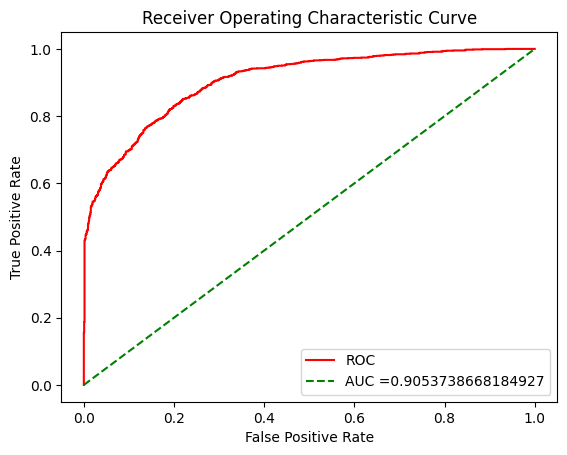

In [ ]:
plot_roc_curve(X_teste, y_teste, XGB_Model)

#### **Gradient Boosting Model**

In [ ]:
def treinar_modelo_GB(params):
    learning_rate = params[0]
    max_depth = params[1]
    max_leaf = params[2]
    subsample = params[3]
    print(params, '\n')
    

    mdl = GradientBoostingClassifier(learning_rate=learning_rate, max_depth=max_depth, 
                                     subsample=subsample, 
                                     max_leaf_nodes= max_leaf,
                                     n_estimators=300, random_state=42)

    mdl.fit(X_train, y_train)

    p = mdl.predict_proba(X_teste)[:, 1]

    return -roc_auc_score(y_teste, p)


space = [(0.001, 0.20), # learning_rate
         (2, 10), # max_depth
         (2, 40), # max_leaf_nodes
         (0.1, 1)] # subsample

RS_GB = gp_minimize(treinar_modelo_GB, space, n_calls=30, random_state=42, verbose = 0)

[0.1595120543851864, 3, 0.8017219002454925] 

[0.11977318143135095, 6, 0.18997742423620262] 

[0.09239052950120759, 5, 0.22858013612974673] 

[0.13052680611682174, 2, 0.7497988950401424] 

[0.18777198909413434, 2, 0.992990403362096] 

[0.12387882041591562, 7, 0.10635967469774567] 

[0.005589422583241736, 6, 0.45987487454373] 

[0.010286466979509471, 10, 0.3094942063872739] 

[0.019030680472031342, 7, 0.4442157921404466] 

[0.1966629462755509, 6, 0.8739463660626887] 

[0.07163131254259637, 10, 0.6151870317853846] 

[0.04614461639858369, 9, 0.38286834537012016] 

[0.19879604759562222, 9, 0.677469474799339] 

[0.001, 9, 0.9447669059728676] 

[0.2, 2, 0.5602846807974068] 

[0.001, 10, 0.5133554743194257] 

[0.2, 2, 0.2778867862157193] 

[0.2, 2, 0.33949573816099793] 

[0.001, 10, 1.0] 

[0.2, 2, 0.9287461145393207] 

[0.15323458026743664, 10, 0.1] 

[0.001, 10, 0.7746377629676089] 

[0.001, 2, 0.6308483156752211] 

[0.2, 10, 0.5693082954345231] 

[0.2, 10, 0.46965198720200907] 

[0.0158566

In [ ]:
print('Os parâmetros escolhidos pelo Bayesian Optimization foram:')
print()
print('learning_rate =',RS_GB.x[0])
print('max_depth =',RS_GB.x[1])
print('max_leaf_nodes =',RS_GB.x[2])
print('subsample =',RS_GB.x[3])

Os parâmetros escolhidos pelo Bayesian Optimization foram:

learning_rate = 0.019030680472031342
max_depth = 7
subsample = 0.4442157921404466


In [ ]:
Result_GB = []
GB_Model = GradientBoostingClassifier(learning_rate=RS_GB.x[0], max_depth=RS_GB.x[1], 
                                       max_leaf_nodes=RS_GB.x[2],
                                       subsample=RS_GB.x[3],
                                       n_estimators=300,
                                       random_state=42)

#### **Validação Cruzada e Resultado do Modelo**

In [ ]:
Cross_validation(GB_Model, X, y, Result_GB)

Repetição:  0
Treino 6519
Valid 2174
Repetição: 0
Acurácia: 0.8100275988960441

Treino 6520
Valid 2173
Repetição: 0
Acurácia: 0.7952139898757478

Treino 6520
Valid 2173
Repetição: 0
Acurácia: 0.8030372756557754

Treino 6520
Valid 2173
Repetição: 0
Acurácia: 0.8122411412793373

Repetição:  1
Treino 6519
Valid 2174
Repetição: 1
Acurácia: 0.8132474701011959

Treino 6520
Valid 2173
Repetição: 1
Acurácia: 0.7970547630004602

Treino 6520
Valid 2173
Repetição: 1
Acurácia: 0.8113207547169812

Treino 6520
Valid 2173
Repetição: 1
Acurácia: 0.805798435342844

Repetição:  2
Treino 6519
Valid 2174
Repetição: 2
Acurácia: 0.8146274149034038

Treino 6520
Valid 2173
Repetição: 2
Acurácia: 0.7984353428439944

Treino 6520
Valid 2173
Repetição: 2
Acurácia: 0.8002761159687068

Treino 6520
Valid 2173
Repetição: 2
Acurácia: 0.8034974689369535

Repetição:  3
Treino 6519
Valid 2174
Repetição: 3
Acurácia: 0.8031278748850046

Treino 6520
Valid 2173
Repetição: 3
Acurácia: 0.8044178554993097

Treino 6520
Valid 217

In [ ]:
print('O modelo de Gradiente Boosting teve a acurácia de:', np.mean(Result_GB))

O modelo de Gradiente Boosting teve a acurácia de: 0.8064862270189842


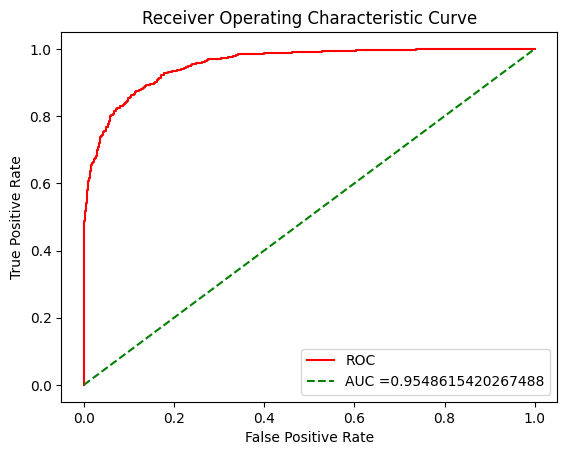

In [ ]:
plot_roc_curve(X_teste, y_teste, GB_Model)

### Resultado Geral (ROC Curve)

In [ ]:
'''O modelo que apresentou melhor acurácia e a melhor curva ROC foi o Gradiente Boosting, sendo assim iremos utilizar ele dentro do conjunto de teste e fazer o submission na competição do Kaggle.'''

#set up plotting area
plt.figure(0).clf();
plt.figure(figsize=(20, 10));
#fit Random Forest model and plot ROC curve

y_pred = RF_Model.predict_proba(X_teste)[:, 1];
fpr, tpr, _ = metrics.roc_curve(y_teste, y_pred);
auc = round(metrics.roc_auc_score(y_teste, y_pred), 4);
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc));

#fit XGBoost model and plot ROC curve

y_pred = XGB_Model.predict_proba(X_teste)[:, 1];
fpr, tpr, _ = metrics.roc_curve(y_teste, y_pred);
auc = round(metrics.roc_auc_score(y_teste, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc));

# Fit Gradient Boosting Model and plot ROC Curve
y_pred = GB_Model.predict_proba(X_teste)[:, 1];
fpr, tpr, _ = metrics.roc_curve(y_teste, y_pred);
auc = round(metrics.roc_auc_score(y_teste, y_pred), 4);
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc));

#add legend
plt.legend();

NameError: name 'RF_Model' is not defined

<Figure size 640x480 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

### Tratamento dos dados de teste e submission model.

#### Função de tratamento dos dados de teste.

In [ ]:
''' Iremos começar salvando a informação do ID do passageiro em uma variável para poder inclui-la no arquivo CSV posteriormente'''
PassengerID = test['PassengerId']

In [ ]:
''' A função pre_process possui todo tratamento que foi realizado no conjunto de treino para ser aplicado também no conjunto de teste, deixando assim os dados preparados para o predict do modelo selecionado.'''

def pre_process(df):

    cols = df.columns

    print('Tratando os valores nulos')

    if df['HomePlanet'].isnull().sum() > 0:
        df['HomePlanet'].fillna('Earth', inplace=True)
    
    if df['CryoSleep'].isnull().sum() > 0:
        df['CryoSleep'].fillna(False, inplace=True)
        
    if df['Destination'].isnull().sum() > 0:
        df['Destination'].fillna('TRAPPIST-1e', inplace=True)

    if df['VIP'].isnull().sum() > 0:
        df['VIP'].fillna(False, inplace=True)
    
    if df['Age'].isnull().sum() > 0:
        df['Age'].fillna(media_idade, inplace=True)

    if df['RoomService'].isnull().sum() > 0:
        df['RoomService'].fillna(rs_mean, inplace=True)

    if df['FoodCourt'].isnull().sum() > 0:
        df['FoodCourt'].fillna(foodcourt_mean, inplace=True)
    
    if df['ShoppingMall'].isnull().sum() > 0:
        df['ShoppingMall'].fillna(shopping_mean, inplace=True)

    if df['Spa'].isnull().sum() > 0:
        df['Spa'].fillna(spa_mean, inplace=True)

    if df['VRDeck'].isnull().sum() > 0:
        df['VRDeck'].fillna(vr_mean, inplace=True)

    print('Criação de novas features')

    df['PassengerGroup'] = df['PassengerId'].str.split('_').str.get(0)
    df['Deck'] = df['Cabin'].str.split('/').str.get(0)
    df['Number_Cabin'] = df['Cabin'].str.split('/').str.get(1)
    df['Side_Cabin'] = df['Cabin'].str.split('/').str.get(2)
    df['total_cost'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'] 
    df['Group_Size'] = df.groupby('PassengerGroup')['PassengerGroup'].transform('count')

    # Preenchendo os valores nulos com 0 das colunas criadas
    df['PassengerGroup'].fillna(0, inplace=True)
    df['Deck'].fillna('F', inplace=True)
    df['Number_Cabin'].fillna(0, inplace=True)
    df['Side_Cabin'].fillna('P', inplace=True)

    df['Number_Cabin'] = df['Number_Cabin'].astype('int64')
    df['PassengerGroup'] = df['PassengerGroup'].astype('int64')
    
    print('Excluindo colunas que não utilizaremos')
    if 'Name' in cols:
        df.drop('Name', axis=1, inplace=True)
    
    if 'Cabin' in cols:
        df.drop('Cabin', axis=1, inplace=True)

    if 'PassengerId' in cols:
        df.drop('PassengerId', axis=1, inplace=True)
    
    print('Alterando formato das variáveis')

    df[['CryoSleep', 'VIP']] = df[['CryoSleep', 'VIP']].astype(int)

    def group_size_cat(groupSize):
        if groupSize == 1:
            return 'Sozinho'
        elif groupSize == 2:
            return 'Casal'
        elif groupSize < 4:
            return 'Familia'
        elif groupSize >= 4:
            return 'Grupo'

    df['Group_Size'] = df['Group_Size'].map(group_size_cat)
    # Aplicando o OrdinalEncoder nas colunas categóricas.

    print('Tratamento Finalizado.')

    
def transf_predict(valor):
    if valor == 1:
        return True
    elif valor == 0:
        return False

#### Submission Model

In [ ]:
''' Como podemos ver todos os dados foram tratados de acordo com a função, agora iremos aplicar o get_dummies e selecionar as variáveis que foram escolhidas pelo selectkbest.'''
pre_process(test)

test = pd.get_dummies(test, columns = cal_categ)
test = test.iloc[:,cols_sel]

Tratando os valores nulos
Criação de novas features
Excluindo colunas que não utilizaremos
Alterando formato das variáveis
Tratamento Finalizado.


In [ ]:
'''Com isso iremos fazer o predict no conjunto de teste e criar uma nova coluna chamada Transported, essa coluna irá receber a função para transformar o 1 e 0 em True e False.'''

Pred_transported = GB_Model.predict(test)
test['Transported'] = Pred_transported

test['Transported'] = test['Transported'].map(transf_predict)
pred = test['Transported'].values


NameError: name 'GB_Model' is not defined

In [ ]:
''' Salvando o arquivo em .csv para fazer o submission no link da competição.'''
sub = pd.Series(pred, index=PassengerID, name='Transported')
sub.to_csv('submission_GB.csv', header=True)

NameError: name 'pred' is not defined